<a href="https://colab.research.google.com/github/michalszczecinski/data-driven-notebooks/blob/master/engineering/industrial_automation_case_study_1e_v1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Code Set Up

In [ ]:
#@title Imports {display-mode: "form"}
import sys
import os
import platform
import random
import itertools
import math
import datetime

import numpy as np
import pandas as pd

# display
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import YouTubeVideo

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# reading google sheets files
import gspread
from oauth2client.client import GoogleCredentials

from collections import OrderedDict
from typing import List, Optional

# print versions
print (f"system: {sys.version}")
print (f"pandas: {pd.__version__}")
print (f"numpy: {np.__version__}")

system: 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
pandas: 1.1.5
numpy: 1.19.5


In [ ]:
# @title Dislay settings  {display-mode: "form"} 

# display all dataframes in cell
InteractiveShell.ast_node_interactivity = "all"

#pandas
pd.set_option("display.float_format", '{:.3f}'.format)
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", 200)

# plotting
sns.set(context='notebook', style="whitegrid", rc={"figure.figsize": (20, 10)})

### Helper functions and snippets

Note: This notebook is created from the template `knowledge_notebook_template.ipynb`. For convenience it inherits all potentially useful imports, helper utils and general structure. That means it is likely not using all the defined functionality.

In [ ]:
# @title Generate Report header with meta information {display-mode: "form"} 
def generate_header(author: Optional[str] = 'szczecinski',
                    title: Optional[str] = 'unknown',
                    description: Optional[str] = 'unknown',
                    prepared_for: Optional[str] = 'learning',
                    tags: Optional[List[str]] = [''],
                    links: Optional[List[str]] = ['']):
    """
    Generates standardised header with meta information describing the report.
    
    Args:
      author: Name of the author.
      title: Title of the report.
      description: Text describing the report.
      prepared_for: Text providing context and purpose of generating the report.
      tags: List of tags for searching.
      links: List of links for reference and cross linking.

    Returns:
      df_meta: Formatted Pandas Dataframe with meta information of the report.
    """
    meta_dict = OrderedDict()

    # Properties provided by author.
    meta_dict['author'] = author
    meta_dict['title'] = title
    meta_dict['description'] = description
    meta_dict['prepared_for'] = prepared_for
    meta_dict['tags'] = str(tags)
    meta_dict['links'] = str(links)

    # Properties auto generated by the system.
    runtime = datetime.datetime
    meta_dict['runtime'] = runtime.now().strftime("%Y-%m-%d %H:%M:%S")
    path = os.getcwd()
    meta_dict['path'] = path
    python_version = platform.python_version()
    meta_dict['python_version'] = python_version
    meta_dict['pandas_version'] = pd.__version__

    df_meta= pd.DataFrame(meta_dict, index=['report_information']).T
    return df_meta

## Automated belt conveyor system for detecting and sorting metalic parts.
[Link to this notebook](https://colab.research.google.com/drive/107YiuEBR5xspjGM_1NSuOXW3vzmesa7d?usp=sharing)

In [ ]:
# setting up header info
author = 'Michal Szczecinski'
prepared_for ='Mechatronics assignment'
title = 'Automated belt conveyor system for detecting and sorting metalic parts.'
description = 'Parts-sorting station using pneumatic power circuit.'
tags = ['#mechatronics', '#industrial-automation', '#belt-conveyor']
links = ['']
generate_header(author=author,
                title=title,
                description=description,
                prepared_for=prepared_for,
                tags=tags,
                links=links)

report_information
author                                                               Michal Szczecinski
title           Automated belt conveyor system for detecting and sorting metalic parts.
description                        Parts-sorting station using pneumatic power circuit.
prepared_for                                                    Mechatronics assignment
tags                      ['#mechatronics', '#industrial-automation', '#belt-conveyor']
links                                                                              ['']
runtime                                                             2021-12-26 07:55:01
path                                                                           /content
python_version                                                                   3.7.12
pandas_version                                                                    1.1.5

## Problem Statement



Figures 1(a) and 1(b) show the layout of a parts-sorting station and its pneumatic power circuit. The pneumatic cylinder, driven by a double-solenoid valve, is used to divert parts into two conveyors based on the material property.

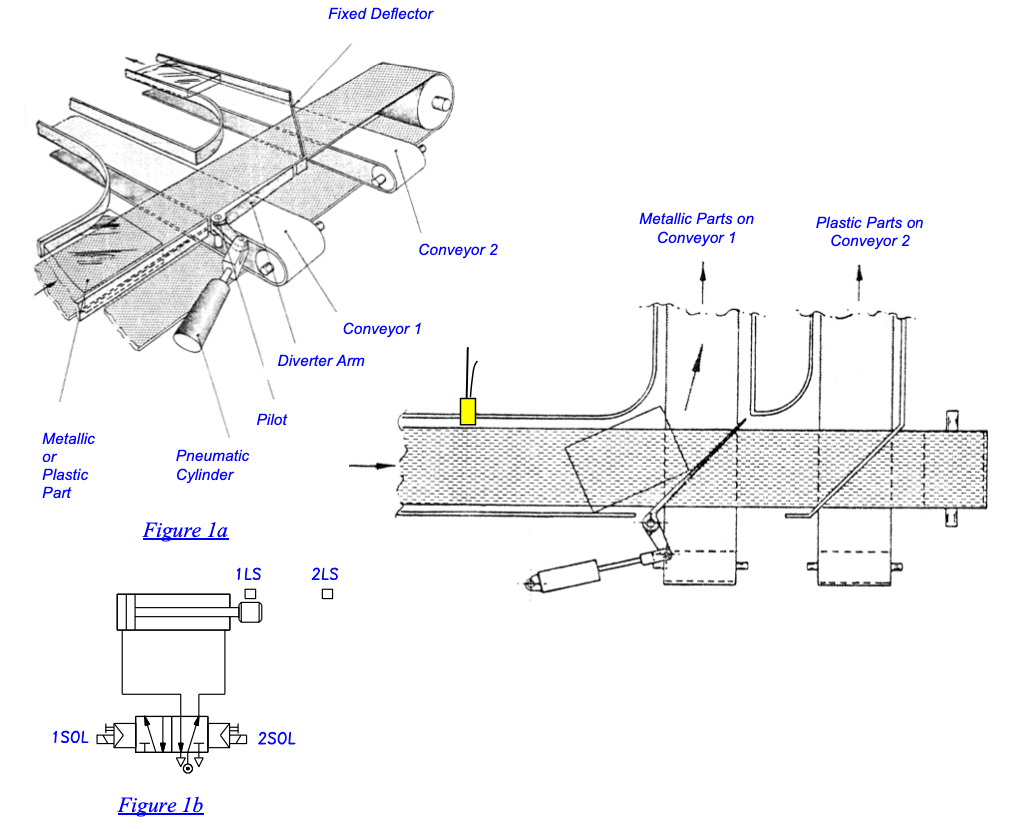 

The operations are to be implemented as follows:

1. When an Auto-Start pushbutton is actuated, a continuous-cycle operation will commence.
2. Whenever sensor 1PS detects a metallic part, the cylinder will extend to its fully-extended position to activate the pivot arm, channeling the part onto conveyor 1. After a time delay of 15 seconds, the cylinder will retract automatically to its initial position awaiting the next
metallic part to arrive.
3. All plastic parts arriving at the station will be allowed to go through and channel onto
conveyor 2.
4. A counter is used to register the number of operating cycles during the continuous-cycle
mode.
5. The continuous-cycle operation will come to a halt when any one of the following conditions
occurs:

  i) a Stop pushbutton is actuated, or    
  ii) the number of counts registered by a counter reaches 10

6. When a Reset pushbutton is activated, the counter will be reset.
7. The user can also activate the diverter in single cycle mode when a Single-Start pushbutton is
pressed.


The control circuit is to be implemented by electrical hardwired logic.

a) Design an Electrical Ladder Diagram to achieve the desired control. 
b) Construct the circuit designed in part (a).  

## Introduction



Our automated system is able to separate plastic from metalic parts by utilising Electro-pneumatic control circuit. 

1. It consists of assembly of 3 conveyor belts (powered by 3 motors).
2. User places the part on the primary conveyor belt.
3. If metalic part is detected by the sensor then the actuator in the form of the pneumatic cylinder is going to extend and push on the diverter arm, which is going to change directory of the part into conveyor belt 1. 
4. If sensor is not activated (turned on) by presence of the metal material then the part is going to continue moving and get deflected by default at the end of the primary conveyor belt to the conveyor belt 2.
 

Video showing operation of a swipe arm using pneumatic cylinder.

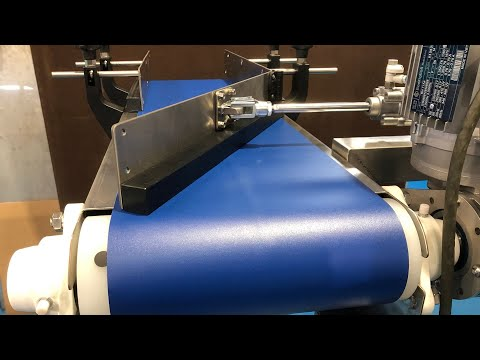

In [ ]:
YouTubeVideo('ImI2R_FFNk0', width=1024, height=576)

## Theory

The Control Chain theory consisting of the four elements provided an overview of the automated machine. Various types of electric and pneumatic components are incorporated to design and build this automated machine.
  
Reduction of human involvement in controlling a machine or process using automation involves the following steps.

a) Replacement of human’s muscles (hands) by some output devices, e.g. the electrical motors, pneumatic actuators or hydraulic cylinders.

b) Replacement of human’s brain by a logic signal processing device such as a computer, micro-controller or programmable controller.
 
c) Replacement of human’s senses (eyes, ears, etc.) by input devices such as limit switches and sensors. 

d) The use of signal conversion means to match the output element with the signal-processing lay

### Belt Conveyors

A belt conveypr consits of two or more pulleys or rollers with a continuous loop of material with the conveyor belt rotating around them. One or both of the pulles may be powered, moving the belt and the material on the belt forward. Powered pulleys or rollers are called drive or driven elements, while the undriven rollers or pulleys are called idlers. Idlers may also be located on the underside of the conveyor for support of the return strand or belt. Motors for belt conveyors are typically located at the head, or pulling end, of the conveyor. For reversing conveyors, the motor may be located in the middle.



Belts may be made of many different materials ranging from rubber or plastic compounds to metal mesh. Many belts are made of composites with an under layer for strength and a cover material to protect the product. Belt conveyors are usually used in applications requiring solid surface, where materials cannot be easily passed across rollers. Belt materials are often chosen based on strength requirements or load, the amount of friction required, and the environment that they are exposed to. Cleats and sidewalks may be attached to the belt surface to help confine materials or reduce the need for high-friction surfaces that may damage products. Cleat spacing and durability are key factors in the choice of material and bonding methods for a cleated belt.


If belt conveyors are used on an incline or decline, the friction coefficient of the belt is typically high. A nose-over section is often placed on the top, bottom or both sections of incline belt conveyors to allow for easy transitions of material from other conveyors or into hoppers. 

Figure 1 shows a cleated conveyor.

Belt conveyors are one of the least expensive types of conveyor. They typically have a metal framework with rollers at each end. The belt may be pulled across a flat surface or bed. For heavier loads, it may also move across additional rollers. These are known as slider bed and roller bed conveyors, respectively. To ensure the belt is at the proper tightness and tracls well across the rollers, the end roller is often adjustable. Rollers may also be crowned to ensure belt centering. [1]

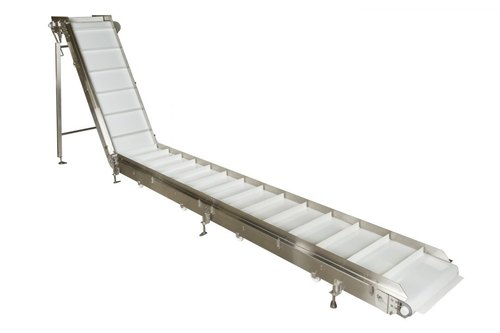

Figure 1 - Cleated incline belt conveyor. 

[Source](https://www.indiamart.com/proddetail/inclined-conveyor-with-modular-cleated-sidewall-belt-10609397297.html) 

#### 10 Hot Types of Belt Conveyor 

1. Cleated Belt Conveyor
2. Inclined Belt Conveyor
3. Flat Belt Conveyor
4. Trough Belt Conveyor
5. Roller Bed Belt Conveyor
6. Portable Belt Conveyor
7. Retractable Belt Conveyor
8. Curved Belt Conveyor
9. Steel Belt Conveyor
10. Special Belt Conveyor

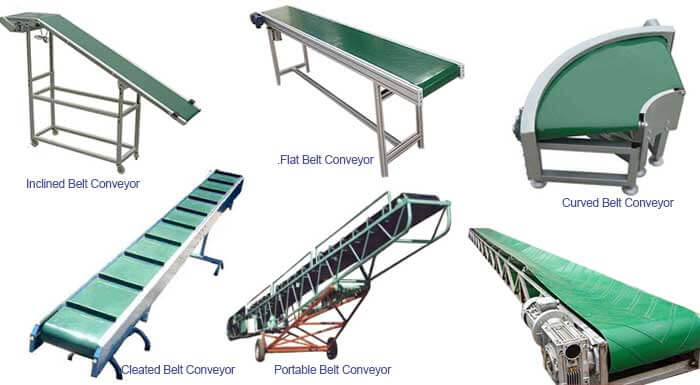

### Sensors

#### Inductive sensors

Inductive sensors respond only to metals and hence are suitable for detecting metallic objects. 

Operating Principle :
  An inductive proximity sensor essentially comprises an oscillator whose windings constitute the sensing face. An alternating magnetic field is generated in front of these windings. 
  
  When a metallic object is placed within the field, the resulting currents induced form an additional load and the oscillation ceases. This causes the output driver to operate and depending on sensor type, a NO, NC or NO plus NC
output signals is produced.

  The terminal connections of a typical inductive sensor which is used in the Industrial Automation laboratory is shown below with its specifications (Figure 2)

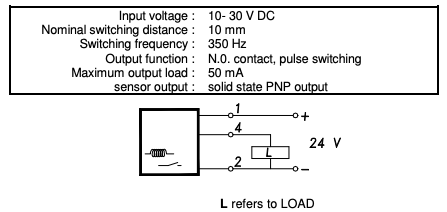

Figure 2 Source; Ngee Ann Polytechnic; INDUSTRIAL AUTOMATION; CHAPTER EP3, Input &
Signal Processing Elements, The Electro-Mechanical Components 

#### Capacitive Sensors


Capacitive proximity sensor can used to detect both metallic and non-metallic objects.

Operating Principle :
 This type of sensor uses an electrode instead of a detector coil. It comprises an oscillator whose
capacitors constitute the sensing surface. When metallic or non-metallic object with
 permissivity > 1 is placed within the field, it changes the dielectric constant and starts the oscillator.
 This cause the output driver to operate and depending on sensor, a NO or NC or NO plus NC output
signal is produced.
 The terminal connections of a typical capacitive sensor as used in the Industrial Automation
laboratory is shown below with its specifications (Figure 16): 

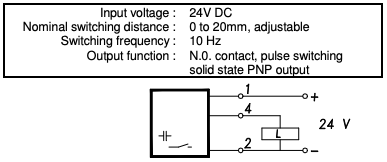

Figure 3: The terminal connections of a typical capacitive sensor as used in the Industrial Automation laboratory  

## Design

### Control Chain and equipment

| element                   | description                                                     |
|---------------------------|-----------------------------------------------------------------|
| Output Element            | Pneumatic Double Acting Cylinder                                |
| Final Control Element     | 5/2 way Double Solenoid Directional Control Valve |
| Signal Processing Element | Control Relay, Timer Relay, Counter Relay,                      |
| Input Element             | Autostart-PB,  Stop_PB,  Reset_PB, Single_start_PB, Inductive Sensor            |

### Pneumatic drive circuit

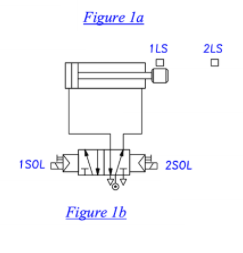

#### Data sheet – Valve size 26 mm

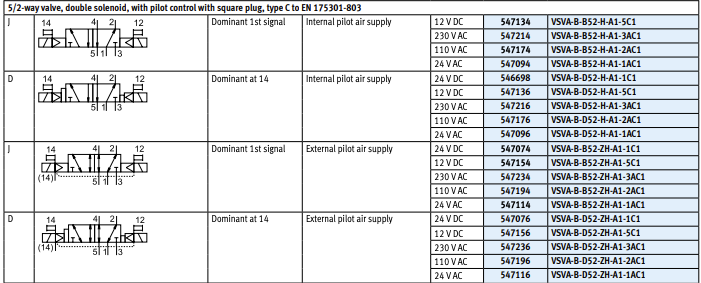

[5/2-way double solenoid valve - 167076](https://www.festo-didactic.com/ov3/media/customers/1100/00148063001075223504.pdf)

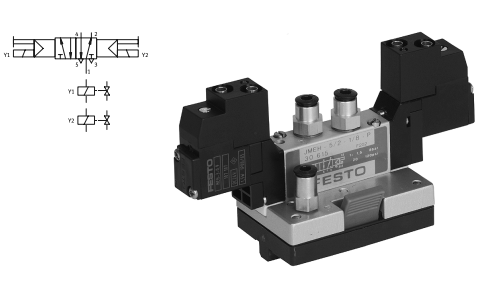

### Data sheet

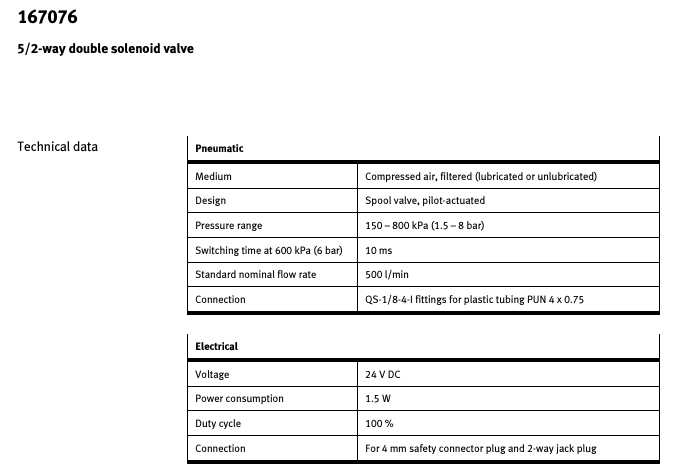

### Double acting cylinder

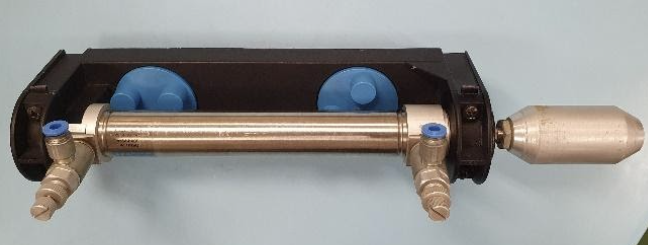

### Limit Switch

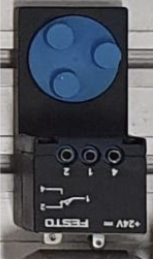

### Control Relay

* 1aCR
* 1 CR

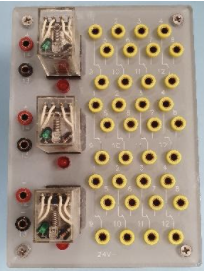

### Timer Relay

* 1TR

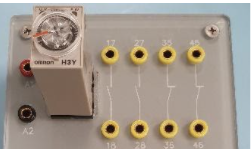

### Counter Relay

* 1CTR



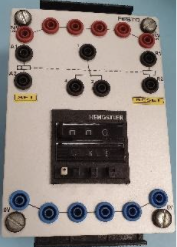

### Push Button Switch

* Autostart_PB
* Stop_PB
* Reset_PB
* 1LB

### Electrical Control Ladder Diagram

Considerations:

1. What is considered "Single Cycle"?

Description of problem states: "The user can also activate the diverter in single cycle mode when a Single-Start pushbutton is pressed". 

Because it mentions the "diverter" I make here assumption that cycle is counted only when the diverting arm is activated (meaning metal part is detected). Alternative meaning could be that single cycle would indicate filtering single part, which would require a different design catering for identifying the plastic parts. In such cycle even though the diverted arm would not be activated but the system would stop after plastic arm passing through the conveyor belt.

2. What about the motor control? 

In the problem statement operations of motors are excluded, so I don't include it in the design of the system and focus on the operation of the diverter arm only. In real exmple of the conveyor belt system we would need to handle operation of at least 3 motors, turning them on and off and calibrate speed based on the desired operations.

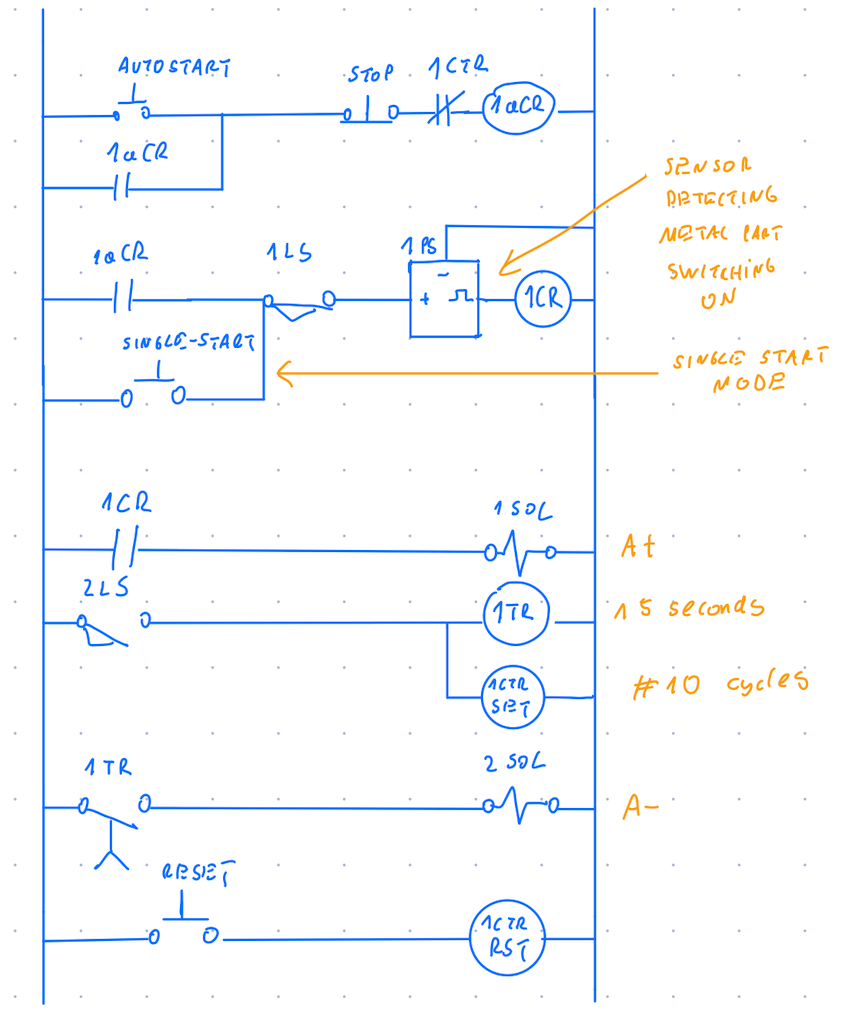

[PLC fiddle design](https://www.plcfiddle.com:/fiddles/2ed29d7b-35af-470e-83e9-6f87dba4df26)

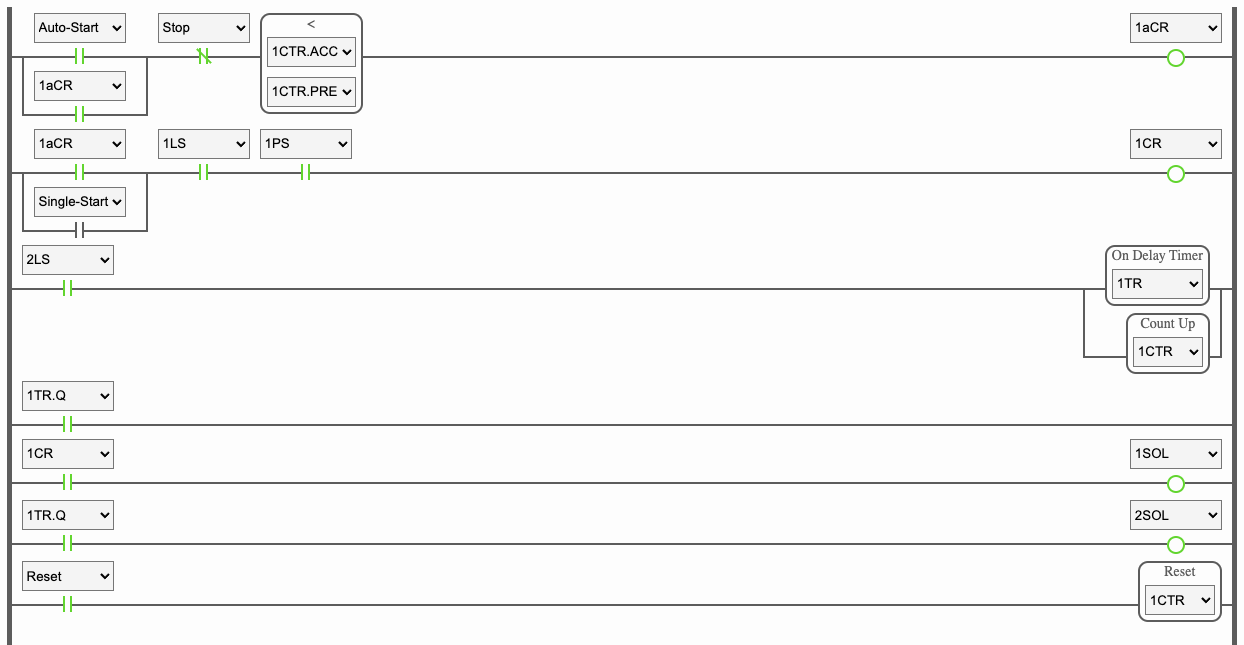

In [ ]:
# list of parts for final specification
push_buttons = ['Auto-Start','Stop','Single-Start']
coils =['1aCR','1CR']
timers = ['1TR']
counters = ['1CTR']
limit_switches = ['1LS', '2LS']
sensors = ['1PS']

### Selection of Cylinders

Selection of a suitable cylinder for a particular application will be based on:

* Load to be moved 
* Stroke length required

We need to:
1. Determine the output force, bore diameter and rod diameter of pneumatic cylinder.
2. Select a cylinder and a valve for a particular application. 
3.Calculate air consumption
4. Determine the operating power requirements for a pneumatic system.

#### Selection procedures

1. Determine whether cylinder is single or double-acting, rodless or other types.
2. Calculate bore diameter.
3. Select stroke length from supplier's catalogue.
4. Select rod diameter from the buckling chart.
5. Type of Mounting
6. Other consideration:     
* Prevent piston from turning?
* Consider the angles
* Consider friction
* Add speed requirements into the equation
* Withstand bending loads?
* Size & type of connection.
* Special requirements, e.g contactless sensing, position, cushioning, etc.

### Forces in Cylinders

#### Mechanics principles in the analysis [7]

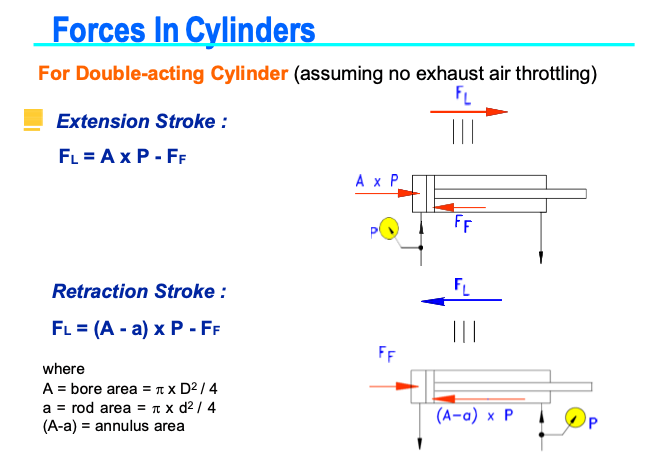

Source: Ngee Ann Polytechnic, EP7 Practical Considerations of Pneumatic System Implementatins

\begin{align}
F_l &= A * P - F_f \tag{1} \\
A &= \frac{\pi * D^2}{4} \tag{2} \\
\end{align}

where<br>
A = bore area   
D = bore diameter   
Fl = load     
Ff = friction force

\begin{align}
F_l &= A * P - F_f  \\ 
F_l + F_f &= A * P  \\ 
F_l + F_f &= \frac{\pi * D^2}{4} * P \tag{from 2} \\ 
\frac{F_l + F_f}{P} &= \frac{\pi * D^2}{4} \\ 
\frac{F_l + F_f}{P} * \frac{4}{\pi} &= D^2 \\ 
\frac{(F_l + F_f)*4}{P*\pi} &= D^2 \\ 
D &= \sqrt{\frac{(F_l + F_f)*4}{P*\pi}} \\ 
\end{align}

#### Assumptions

Load acting on the cylinder = 50 N.

Workpiece movement = 100 mm.     

Compressed air Pressure = 6 bar. 


In [ ]:
# workpiece movement in m 
workpiece_movement = 0.100
# pressure in pascal (N/m^2)
P = 6 * 10**5
# load acting on cylinder in N
Fl = 50
# friction force in N
Ff = 0

In [ ]:
# diameter in meters (m)
D = math.sqrt(
    (Fl+Ff)*4/(P * math.pi)
              )
print(f'Bore Diameter: {D*10**3} mm')

Bore Diameter: 10.300645387285055 mm


#### Buckling load chart [7]

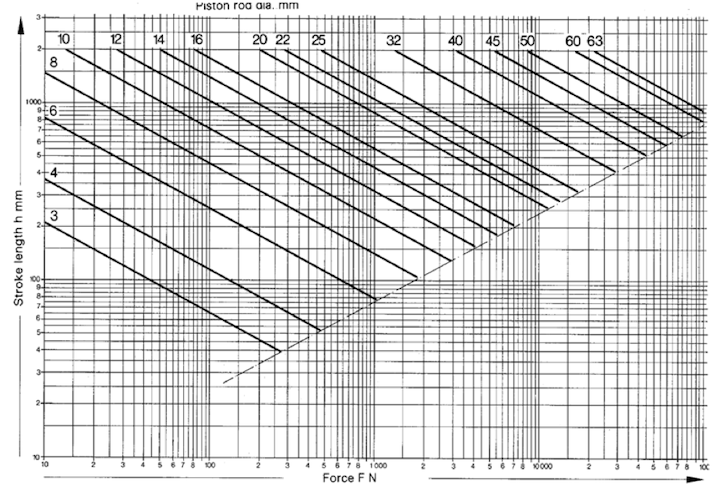

Selecting rod diameter: 4 mm

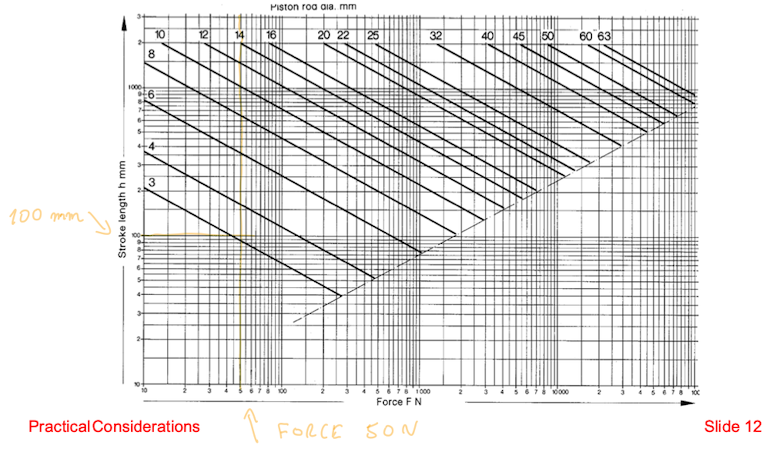

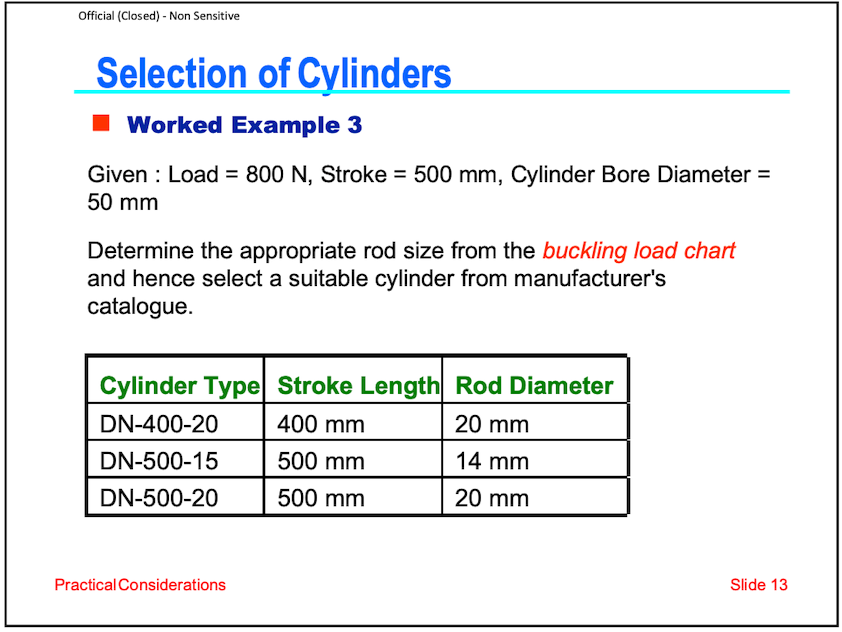

In [ ]:
# selecting cylinder type based on buckling chart
# example DN-400-20

stroke_length = 0.100
d = 0.004
cylinder_type = f'DN-{round(stroke_length*10**3)}-{round(d*10**3)}'
print (f'cylinder_type: {cylinder_type}')

cylinder_type: DN-100-4


Mounting of cylinders [7]

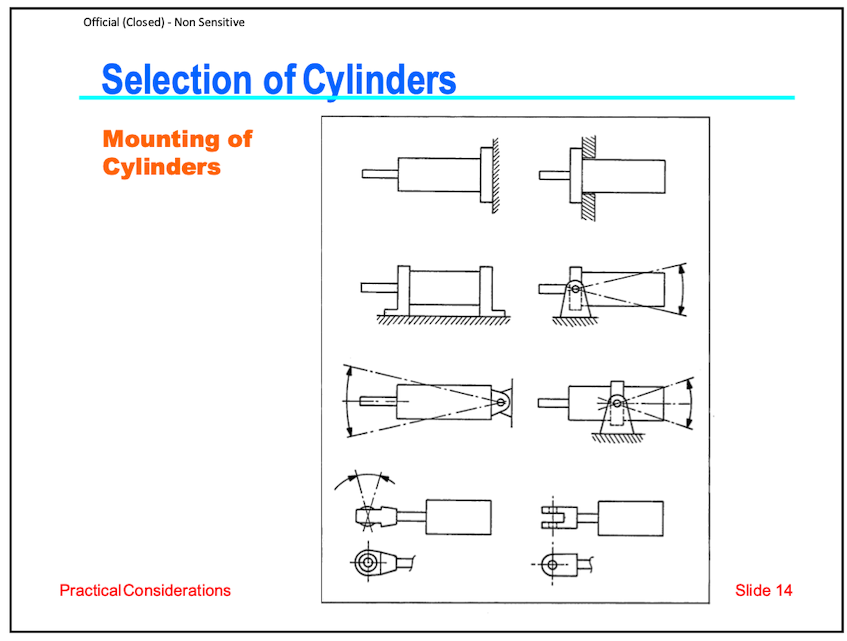

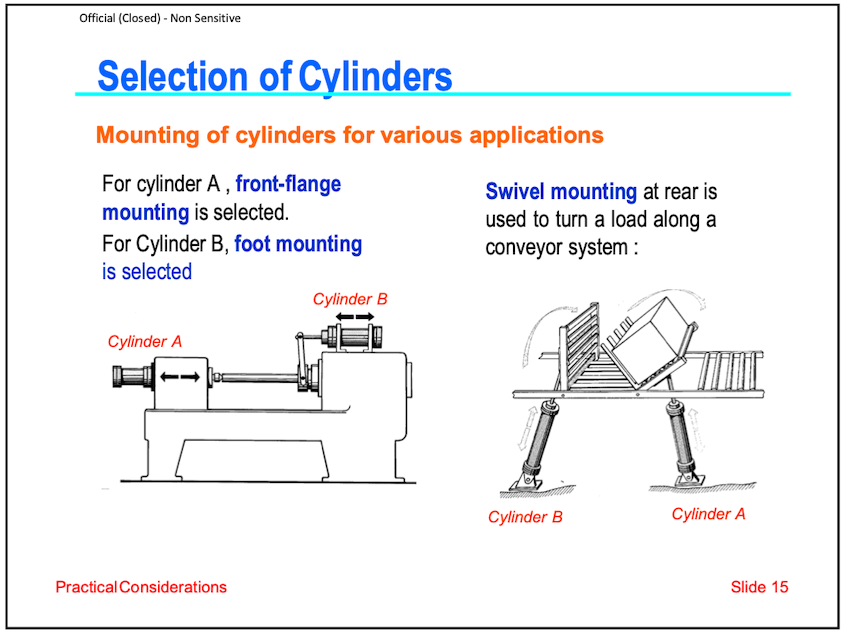

In [ ]:
# mounting type
mounting_type = 'swivel mounting'

### Data sheet Festo and example calculations

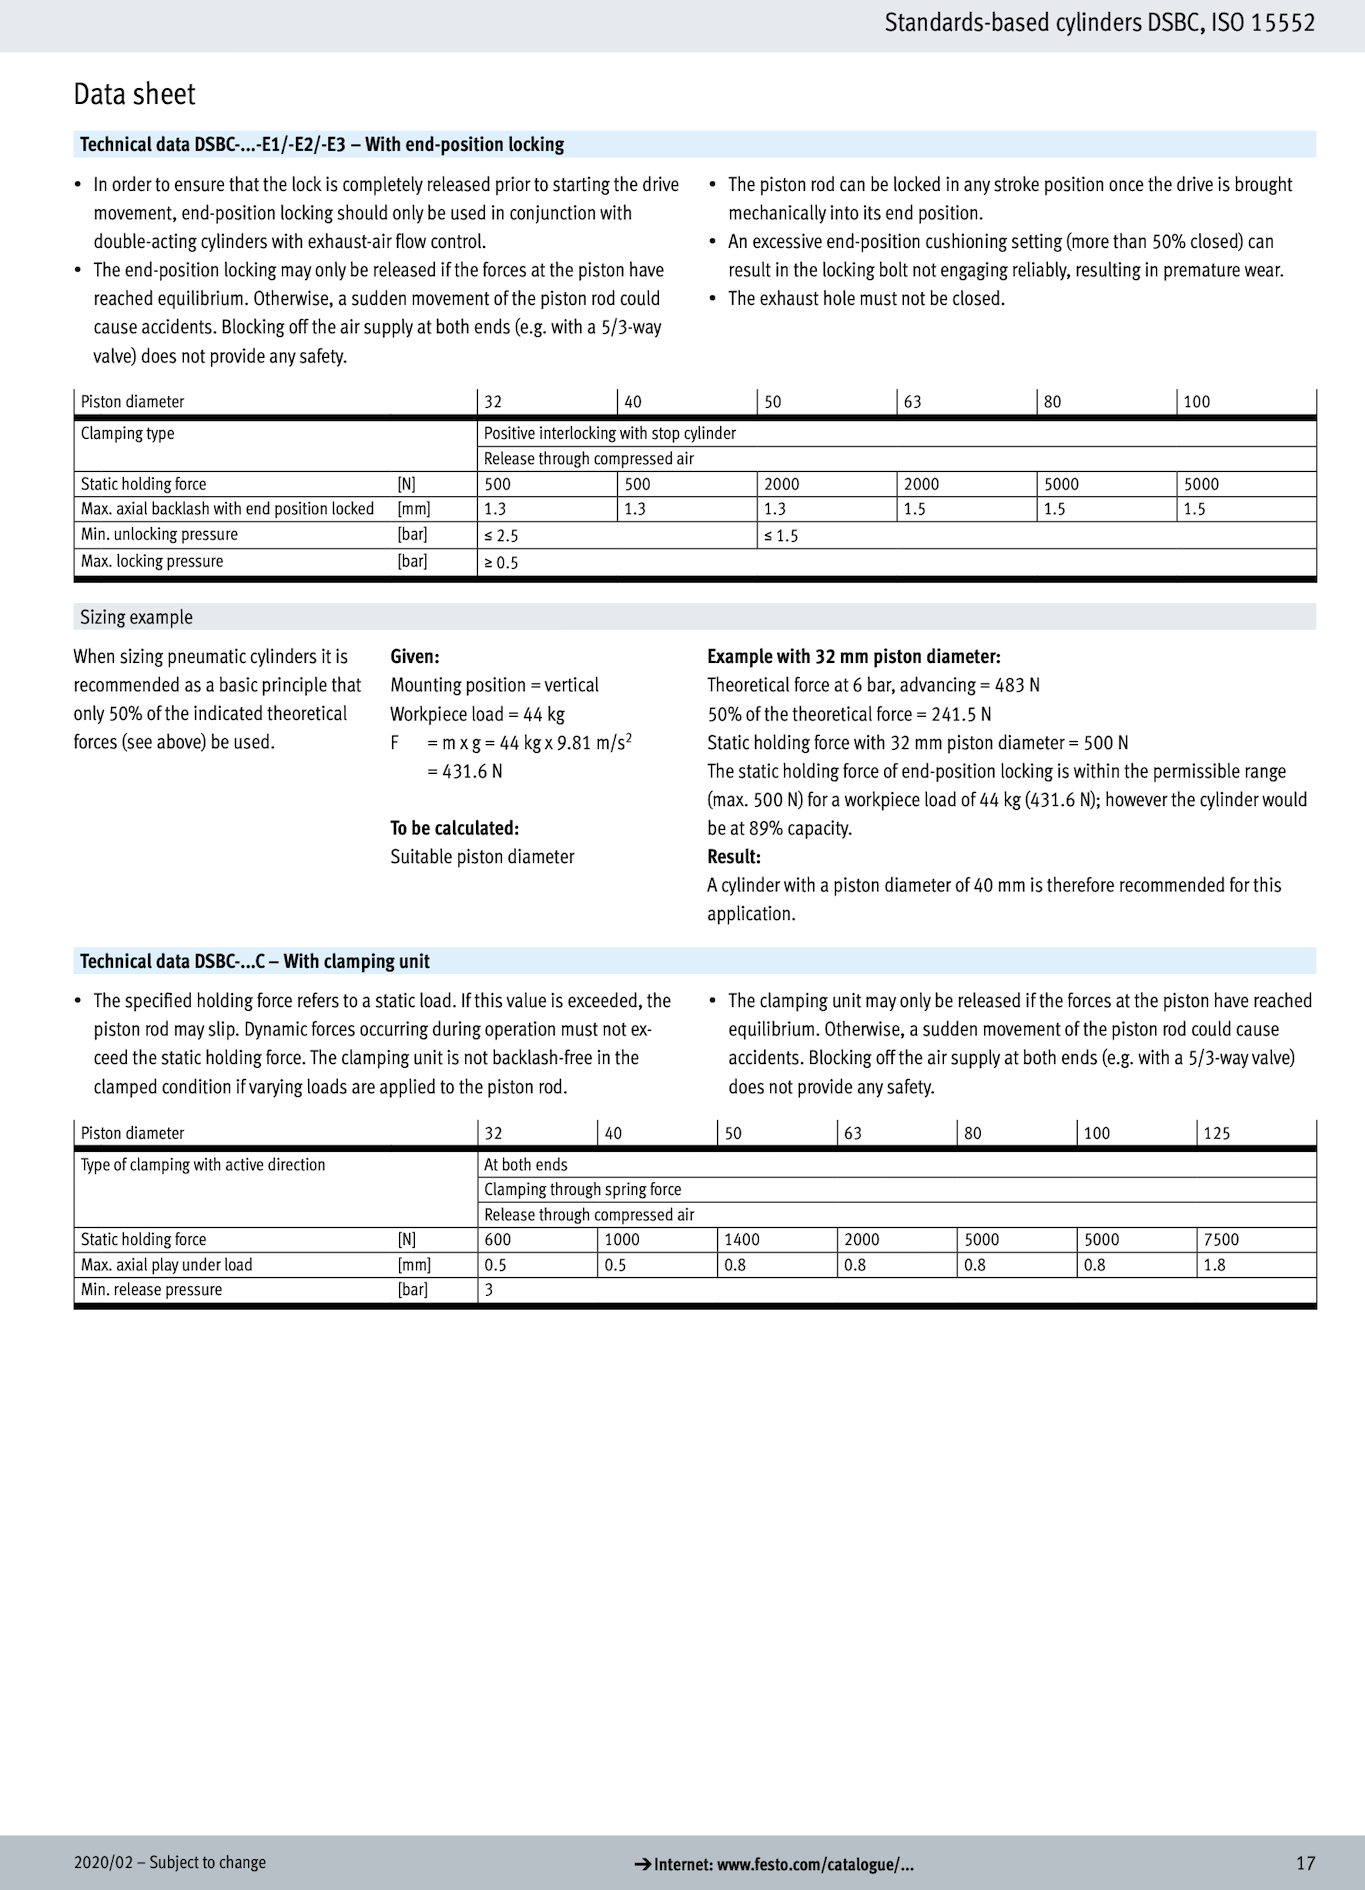

### Final specification table

In [ ]:
data_spec = {
    'push buttons': str(push_buttons),
    'coils': str(coils),
    'limit switches': str(limit_switches),
    'timers':str(timers),
    'counters': str(counters),
    'sensors': str(sensors),
    'stroke_length': stroke_length,
    'cylinder_type': cylinder_type,
    'mounting_type': mounting_type,
             }

In [ ]:
pd.DataFrame(data=data_spec, index=['value']).T

value
push buttons    ['Auto-Start', 'Stop', 'Single-Start']
coils                                  ['1aCR', '1CR']
limit switches                          ['1LS', '2LS']
timers                                         ['1TR']
counters                                      ['1CTR']
sensors                                        ['1PS']
stroke_length                                    0.100
cylinder_type                                 DN-100-4
mounting_type                          swivel mounting

## Discussion


### Limitations

In the current specification the system is not really sorting between metalic and plastic objects, but rather between metalic and non-metalic objects. For this to be limited only to metalic and plastic parts we would need to design a special sensor combination, also we would need to decide how to handle "other" (non metalic and non plastic) parts. Based on the way problem was framed I assume it is out of the scope for this exercise and that we assume only metalic and plastic parts will be loaded to the system.

### Extension

Our system can be modified and adapted for number of possible scenarios, for example we could replace the inductive sensor with a more general AI vision system that could recognize and differentiate designated objects (for example pen vs pencils, apples vs pears etc.).

For personal exploration and use we could for example experiment and prototype with the [AI Vision Kit](https://aiyprojects.withgoogle.com/vision).

It is a DYI kit provided by Google that includes camera and is powered by Raspberry Pi. Using it we can train our own TensorFlow models in Python. We would apply typical methodology for training classification models, including provisioning and splitting machine learning datasets for training, test and validation.

More investigation has to be done in order to determine how to best interface between Raspberry PI of the Vision Kit and the actuators (like DC motors and pneumatic cylinders).

## Conclusion

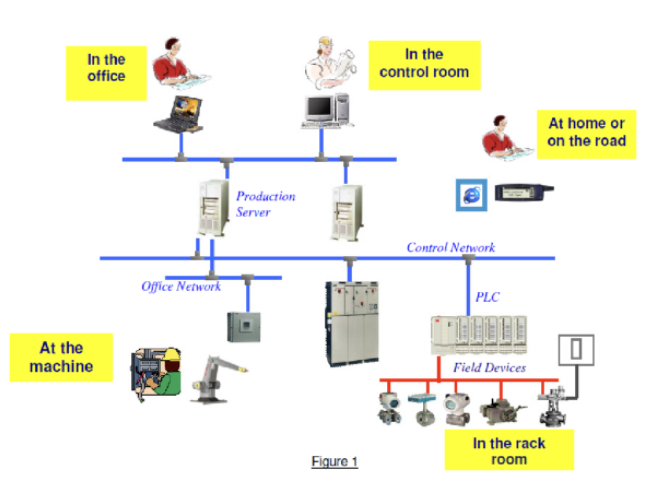

In the exercise above we have:

1. Presented scenario we would like to automate - conveyor belt system for segregating parts based on the detection of a metal material.

2. Described equipment and theory underlying our system - belt conveyors built and types, sensor types, pneumatic drive elements etc.

3. Described control chain and designed electrical control ladder diagram.

4. Presented mechanics principles and calculated the parameters needed for the selection of actuating cylinder.

5. Presented data sheets for an example equipment.

6. Discussed improvements and extension to the system - including AI object detection system based on DIY AI kit and tensorflow library from Google.

There are number of things I would like to improve and extend in this design, particularly in regards to study of mechanics of the system (ideally after we cover relevant module) and based on a better intuition improve the design of mechanical elements and extend calculations to cover more details and workings of the system. 

Ideally, we would build the prototype of the system and analyse how the behaviour changes when we vary parameters like pressure, diameters sizes, stroke length, motor speed, sensor positioning and sensitivity etc. 


### Appendix A -  Words meaning and origin

#### Buckling

>buckle - bend and give way under a weight or force

> Buckling is a sudden, large, and unstable lateral deflection. It can be associated with only a small increase in compressive load above a critical level, known as the buckling load. The corresponding stress can be far less than the yield strength of the rod material. Once it occurs, buckling leads to instability and collapse of the piston rod. This is why buckling in “failure mode” is potentially highly dangerous and may result in serious accidents.

Source: [www.hydraulicspneumatics.com](https://www.hydraulicspneumatics.com/technologies/cylinders-actuators/article/21887243/understanding-buckling-strength-of-hydraulic-cylinders)

#### "Bore" meaning and word origin

> bore - the space inside a pipe or tube, or the diameter (= measurement across the widest part) of this space' also short for "borehole"

> borehole - a deep, narrow hole made in the ground, especially to locate water or oil.

> bore(verb) - to make a hole in something using a tool:

## References

[1] Industrial Automation Hands-On, Frank Lamb 2013

[2] Festo Pneumatic cylinder catalogue

[3] Festo Directional Control valve catalogue

[4] [Festo datasheet - 5/2-way double solenoid valve](https://www.festo-didactic.com/ov3/media/customers/1100/00148063001075223504.pdf)

[5] Ngee Ann Polytechnic; INDUSTRIAL AUTOMATION; CHAPTER EP3, Input &
Signal Processing Elements, The Electro-Mechanical Components  

[6] Industrial Automation and Robotics, A.K. Gupta, S.K. Arora, J.R Westcott

[7] Ngee Ann Polytechnic; INDUSTRIAL AUTOMATION; CHAPTER EP7, Practical Considerations of Pneumatic System Implementations


In [ ]:
# @title Converting and exporting output {display-mode: "form"} 

# mount drive to access .ipynb file
from google.colab import drive
drive.mount('/content/drive')

# covert and export output 
!cp 'drive/My Drive/Colab Notebooks/industrial_automation_case_study_1e_v1.0.ipynb' ./
!jupyter nbconvert --to HTML "industrial_automation_case_study_1e_v1.0.ipynb"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[NbConvertApp] Converting notebook industrial_automation_case_study_1e_v1.0.ipynb to HTML
[NbConvertApp] Writing 4767306 bytes to industrial_automation_case_study_1e_v1.0.html
